In [4]:
from tensorflow import keras
from PIL import Image
import cv2
import tensorflow as tf
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import skimage

In [29]:
dir = './X4 Urban100/X4/HIGH x4 URban100/'

In [30]:
X = []
y = []

In [31]:
for d in list(os.walk(dir))[0][2]:

    img = np.array(Image.open(f"{dir}{d}"))[0:560, 0:560]

    noise = np.random.normal(0,15,img.shape)
    
    y.append(img/255)
    X.append((img+noise)/255)

In [59]:
X_resize = np.array(X)[-20:-10]
y_resize = np.array(y)[-20:-10]

In [43]:
X_resize.shape, y_resize.shape

((10, 560, 560, 3), (10, 560, 560, 3))

In [34]:
def pixel_mse_loss(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )

def PSNR(y_true,y_pred):
  mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
  return 20 * log10(1 / (mse ** 0.5))

def log10(x):
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

In [35]:
model = keras.models.load_model('./denoiserUrban15.h5',{"PSNR":PSNR})

In [49]:
def reconPatches(img):
    
    patch_size = 112
    n_col,n_row,n_channel = (560, 560, 3)
    n_patch = n_row*n_col // (patch_size**2)
    patches = tf.reshape(img,[n_patch,patch_size,patch_size,n_channel])
    rows = tf.split(patches,n_col//patch_size,axis=0)
    rows = [tf.concat(tf.unstack(x),axis=1) for x in rows] 
    recon = np.array(tf.concat(rows,axis=0))

    return recon

In [61]:
avg_sum=0
max_psnr=0
for i in range(len(X_resize)):
    extracted_patches = tf.image.extract_patches(images=tf.expand_dims(X_resize[i],0),sizes=[1,112,112,1],strides=[1,112,112,1],padding='VALID',rates=[1,1,1,1])
    X_patches = list(tf.reshape(extracted_patches,[-1,112,112,3]))
    extracted_patches = tf.image.extract_patches(images=tf.expand_dims(y_resize[i],0),sizes=[1,112,112,1],strides=[1,112,112,1],padding='VALID',rates=[1,1,1,1])
    y_patches = list(tf.reshape(extracted_patches,[-1,112,112,3]))

    res = model.predict(np.array(X_patches),verbose=True)

    reconstructed_X = reconPatches(res)
    reconstructed_y = reconPatches(y_patches)

    psnr = PSNR(reconstructed_y,reconstructed_X)


    avg_sum += psnr
    avg_sum /= 2
    max_psnr = max(max_psnr,psnr)
print("Avg PSNR: ", avg_sum, "Max PSNR: ",max_psnr)

1/1 [==============================] - 0s 19ms/step
Avg PSNR:  tf.Tensor(34.230599650363615, shape=(), dtype=float64) Max PSNR:  tf.Tensor(35.81651203385877, shape=(), dtype=float64)


In [65]:
extracted_patches = tf.image.extract_patches(images=tf.expand_dims(X_resize[5],0),sizes=[1,112,112,1],strides=[1,112,112,1],padding='VALID',rates=[1,1,1,1])
X_patches = list(tf.reshape(extracted_patches,[-1,112,112,3]))
extracted_patches = tf.image.extract_patches(images=tf.expand_dims(y_resize[5],0),sizes=[1,112,112,1],strides=[1,112,112,1],padding='VALID',rates=[1,1,1,1])
y_patches = list(tf.reshape(extracted_patches,[-1,112,112,3]))
res = model.predict(np.array(X_patches),verbose=True)
reconstructed_X = reconPatches(res)
reconstructed_y = reconPatches(y_patches)
skimage.metrics.peak_signal_noise_ratio(reconstructed_X,reconstructed_y,data_range=1)

1/1 [==============================] - 0s 23ms/step


35.0043840935355

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


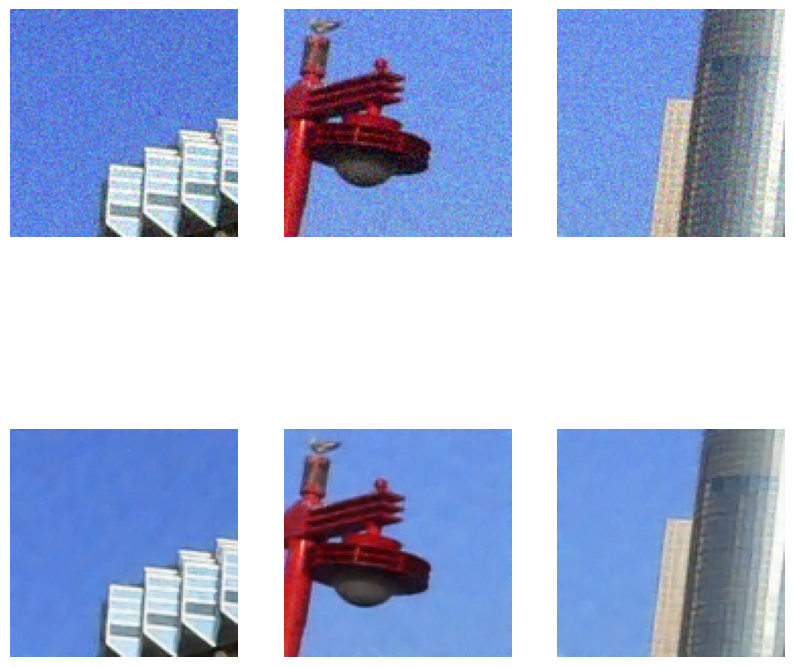

In [118]:
fig,axes = plt.subplots(nrows=2,ncols=3,figsize=(10,10))
axes[0][0].axis('off')
axes[0][0].imshow(X_patches[8].numpy())
axes[0][1].axis('off')
axes[0][1].imshow(X_patches[15].numpy())
axes[0][2].axis('off')
axes[0][2].imshow(X_patches[16].numpy())

axes[1][0].axis('off')
axes[1][0].imshow(res[8])
axes[1][1].axis('off')
axes[1][1].imshow(res[15])
axes[1][2].axis('off')
axes[1][2].imshow(res[16])

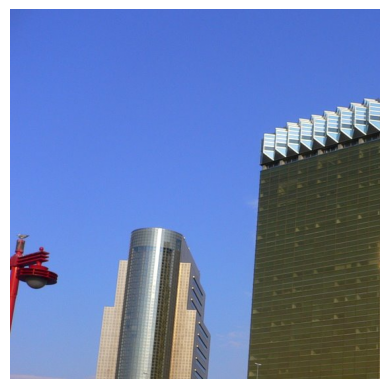

In [130]:
plt.axis('off')
plt.imshow(y_resize[5])

In [131]:
PSNR(y_resize[5],y_resize[5])

<tf.Tensor: shape=(), dtype=float64, numpy=inf>